[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/witchapong/build-ai-based-applications/blob/main/vision/2_object_detection_yolo.ipynb)

# Object Detection
In this notebook, we'll explore an application of a deep learning model (ML) in object detection by detecting cars within images using the [Car Object Detection Dataset](https://www.kaggle.com/datasets/sshikamaru/car-object-detection). Object detection refers to the task of finding and classifying all instances of objects from a domain of interests (as we train an object detection model) within an image. We'll use [YOLO](https://www.datacamp.com/blog/yolo-object-detection-explained), a state-of-the-art real-time object detection algorithm, for our object detection task.

In [1]:
# download an unzip car images
!pip install kaggle
# download dataset from Kaggle
!kaggle datasets download sshikamaru/car-object-detection
# unzip image data
!unzip -q car-object-detection.zip -d car-object-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
 79%|███████████████████████████████▊        | 89.0M/112M [00:00<00:00, 237MB/s]
100%|█████████████████████████████████████████| 112M/112M [00:00<00:00, 230MB/s]


In [2]:
import os
for dirname, _, filenames in os.walk('car-object-detection/'):
    for filename in filenames:
        if not filename.endswith(".jpg"):
            print(os.path.join(dirname, filename))

car-object-detection/data/train_solution_bounding_boxes (1).csv
car-object-detection/data/sample_submission.csv


In [3]:
train_data_path = "car-object-detection/data/training_images"
test_data_path = "car-object-detection/data/testing_images"
train_bboxes_csv_path = "car-object-detection/data/train_solution_bounding_boxes (1).csv"

In [4]:
import pandas as pd
import numpy as np
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import warnings

warnings.filterwarnings("ignore")

try:
    from ultralytics import YOLO
except:
    print("Installing `ultralytics`...")
    !pip install ultralytics
    from ultralytics import YOLO

Installing `ultralytics`...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Read bounding box annotations

In [5]:
bboxes = pd.read_csv(train_bboxes_csv_path)
print("total images file in training directory:", len(os.listdir(train_data_path)))
print("total bounding boxes:", len(bboxes))
print("unique images:", bboxes["image"].nunique())

total images file in training directory: 1001
total bounding boxes: 559
unique images: 355


# Arrange data into appropriate directories for training YOLO model

In [6]:
data_path = os.path.join(os.getcwd(), "data")
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

In [7]:
class ImageReadError(Exception):
    """Custom exception for image read errors."""
    def __init__(self, message="Failed to read the image. The file might be missing or corrupted."):
        self.message = message
        super().__init__(self.message)

In [8]:
# YOLO format acccepts normalized X, Y center & W, H of bounding box
def convert_bbox_to_YOLO_format(image_path, bbox):
    try:
        image = cv2.imread(image_path)
        
        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")

        (h, w) = image.shape[:2]
        xmin, ymin, xmax, ymax = bbox
        x_cen = (xmax + xmin) / 2. / w
        y_cen = (ymax + ymin) / 2. / h
        box_w = (xmax - xmin) / w
        box_h = (ymax - ymin) / h

        return (x_cen, y_cen, box_w, box_h)
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return

In [9]:
for _, r in bboxes.iterrows():
    
    # format for YOLO
    img_path, bbox = r["image"], r[1:].values
    full_img_path = os.path.join(train_data_path, img_path)
    YOLO_format_bbox = convert_bbox_to_YOLO_format(full_img_path, bbox)
    YOLO_format_bbox = np.array(YOLO_format_bbox).astype(str)

    # save the formatted bounding box as text file
    with open(os.path.join(labels_path, f"{img_path.replace('.jpg', '')}.txt"), "w+") as f:
        f.write("0 " + " ".join(YOLO_format_bbox) + "\n")

    # copy an image to a new directory
    shutil.copy(full_img_path, os.path.join(images_path, img_path))

**Creating model configuation (yaml file) for YOLO model training**

The configuration file specifies data path, training and validation directory inside the data path, number of object classes (1), and object names (only 'car' here).

In [10]:
with open(os.path.join(os.getcwd(), "dataset_custom.yaml"), "w") as f:
    f.write(f"path: {data_path}\n")
    f.write("train: images\n")
    f.write("val: images\n\n")
    f.write("nc: 1\n\n")
    f.write("names: ['car']\n")

# Display images with annotations

In [11]:
def display_image_with_bbox(image_path, bboxes):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")
        else:            
            for bbox in bboxes:
                x1, y1, x2, y2 = map(int, bbox)
                # Draw rectanlge:  (start_point, end_point, color, thickness)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Dispaly an image 
            plt.imshow(image_rgb)
            plt.axis("off")
            plt.title("Image with detected Car (if present)")

    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")


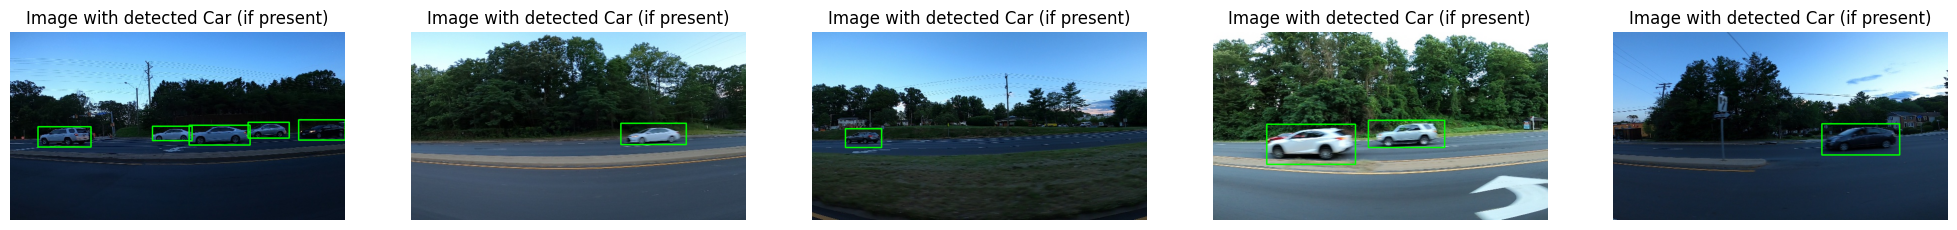

In [12]:
N = 5

plt.figure(figsize=(25, N))

uniq_imgs = bboxes["image"].unique()
n_imgs = len(uniq_imgs)

rand_imgs = np.random.choice(uniq_imgs, N, replace=False)

for i in range(N):
    
    plt.subplot(1, N, i + 1)
    
    img = rand_imgs[i]
    img_bboxes = bboxes.query("image == @img")
    img = img_bboxes["image"].values[0]
    img_path = os.path.join(train_data_path, img)

    _bboxes = []
    for _bbox in img_bboxes.values[:, 1:]:
        _bboxes.append(tuple(_bbox))
        
    display_image_with_bbox(img_path, _bboxes)

# Train the `YOLO11n` model
Next, we'll train the `YOLO11n` for a number of iterations based on `epochs`.

In [13]:
dataset_yaml_path = os.path.join(os.getcwd(), "dataset_custom.yaml")

pretrained_weights = "yolo11n.pt"  # using YOLOv11n

epochs = 30
batch_size = 16
img_size = 640 
device = "0" if torch.cuda.is_available() else "cpu"

In [14]:
model = YOLO("yolo11n.pt")

model.train(
    data=dataset_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=False
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 77.9MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/dataset_custom.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/data/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 1260.98it/s]

train: New cache created: /kaggle/working/data/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.46G      1.474      3.039      1.148          9        640: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]


                   all        355        355    0.00332      0.997       0.53       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.37G       1.34      2.018      1.142         10        640: 100%|██████████| 23/23 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]

                   all        355        355    0.00332      0.997      0.161      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.37G      1.292      1.779      1.129          9        640: 100%|██████████| 23/23 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

                   all        355        355       0.84       0.38      0.609        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.38G      1.302      1.715      1.146          6        640: 100%|██████████| 23/23 [00:03<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        355        355      0.753      0.283      0.637      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.38G      1.228      1.589      1.105          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]

                   all        355        355      0.677      0.857      0.758      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.37G      1.285      1.534       1.14          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.85it/s]

                   all        355        355      0.703      0.686      0.729      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.36G      1.311      1.459       1.13          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]

                   all        355        355      0.711      0.693      0.732      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.37G      1.214      1.279      1.109          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.87it/s]


                   all        355        355      0.703      0.906      0.792      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.38G      1.234      1.223      1.092          5        640: 100%|██████████| 23/23 [00:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]

                   all        355        355      0.751      0.919      0.864      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.37G      1.175      1.146      1.074          8        640: 100%|██████████| 23/23 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.16it/s]

                   all        355        355      0.774      0.906       0.88      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.36G      1.199      1.102      1.088          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        355        355      0.812      0.834      0.876      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.37G      1.194      1.048      1.073          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.20it/s]


                   all        355        355      0.762       0.94      0.854      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.38G      1.164      1.015      1.077          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        355        355      0.794      0.868      0.867      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.37G      1.182       1.03      1.075          7        640: 100%|██████████| 23/23 [00:03<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all        355        355      0.822      0.834      0.883      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.36G       1.14      1.004      1.065          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.03it/s]

                   all        355        355      0.831      0.907      0.926      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.37G      1.158     0.9618      1.062          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.18it/s]

                   all        355        355      0.793      0.932       0.89      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.38G      1.164     0.9097      1.078          8        640: 100%|██████████| 23/23 [00:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


                   all        355        355      0.824      0.907      0.913       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.37G      1.145      0.902      1.055          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.09it/s]

                   all        355        355      0.837      0.938      0.942      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.36G      1.152     0.8765      1.068          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]

                   all        355        355      0.866      0.943      0.944      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.37G      1.135     0.8634      1.059          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]

                   all        355        355      0.891      0.927      0.957      0.654


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.45G      1.094     0.9562      1.045          3        640: 100%|██████████| 23/23 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.28it/s]

                   all        355        355      0.848      0.932      0.958      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.36G      1.076     0.8567       1.03          2        640: 100%|██████████| 23/23 [00:03<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.17it/s]

                   all        355        355      0.907      0.909       0.96      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.36G      1.052     0.8499      1.035          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.18it/s]

                   all        355        355      0.885      0.936      0.958      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.37G      1.112     0.8179      1.055          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


                   all        355        355      0.878      0.911      0.968      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.38G      1.075     0.7986      1.042          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.19it/s]

                   all        355        355      0.923      0.946      0.976      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.36G      1.033     0.7555      1.036          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.39it/s]

                   all        355        355      0.901      0.978      0.973       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.36G      1.048     0.7541       1.02          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.12it/s]

                   all        355        355      0.951      0.935      0.983      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.37G      1.041     0.7018      1.027          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]

                   all        355        355      0.928      0.982      0.986      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.38G      1.057     0.7089      1.019          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        355        355      0.925       0.98      0.986      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.36G      1.027     0.7019      1.016          3        640: 100%|██████████| 23/23 [00:03<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]


                   all        355        355      0.921      0.987      0.986      0.734

30 epochs completed in 0.055 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


                   all        355        355      0.921      0.987      0.986      0.735
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dd784d65f30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate the model

We'll use the following metrics for evaluating our object detections model.
- **Mean Average Precision (mAP):** mean of area under the precision-recall curve across multiple object classes
- **Precision and Recall:** Precision quantifies the proportion of true positives over all positive predictions, assessing model accuracy in predicting true positives. Meanwhile, Recall represents the proportion of true positives over all actual positives, measuring coverage of a model of detecting a class.

In [15]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")

Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:02<00:00,  8.00it/s]


                   all        355        355      0.921      0.987      0.986      0.734
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2

mAP@0.5: 0.9858561877412291

mAP@0.5:0.95: 0.7336472100385423

Precision: 0.9211392520376894

Recall: 0.9870930431940547

Fitness: 0.7588681078088111


**Save model**

In [16]:
trained_model_dir = os.path.join(os.getcwd(), "model")
trained_model_path = os.path.join(trained_model_dir, "car_detection_yolo.pt")

os.makedirs(trained_model_dir, exist_ok=True)

In [17]:
model.save(trained_model_path)


# Make predictions on test images
Finally, we'll make predictions of test images and randomly display our predictions. Here, we'll specify two key parameters.
- **confidence:** the minimum confidence score of a bounding box in classifying an object.
- **iou:** Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS), a post-processing step for removing overlapped and redundant bounding boxes.

In [18]:
with torch.no_grad():
    results = model.predict(source=test_data_path,conf=0.50,iou=0.75)

In [19]:
# directory for saving predictions on test dataset
!mkdir "predictions"

In [20]:
prediction_dir="predictions"

In [21]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [22]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

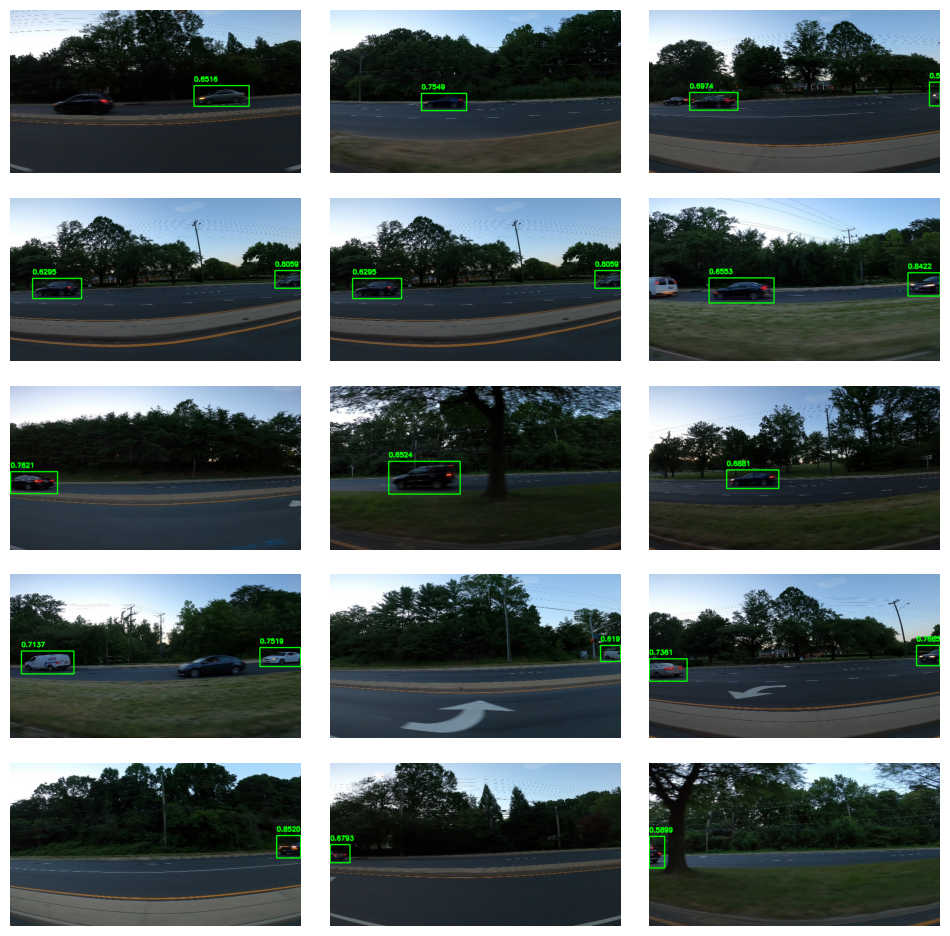

In [23]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_data_path,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])